Imports

In [2]:
import os

from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import nbinom, norm, poisson, gamma
import arviz as az

os.chdir('/app')

from src.web_scraping.scraper import scrap_games

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input parameters for scraping

In [4]:
years = list(range(2022, 2024))
train_year = years[0]
pred_year = years[1]

Scraping

In [5]:
scrap_games(years)

Read data

In [6]:
path = 'src/data/'
path_games = os.path.join(path, 'games/')
seasons_games = {}

# prepare dataframes - drop duplicated rows and sort by date
for year in years:
    seasons_games[year] = pd.read_csv(os.path.join(path_games, f'{year-1}_{year}_season.csv')).drop_duplicates().sort_values(by='start_time').reset_index(drop=True)
print(seasons_games)

{2022:                      start_time              away_team  away_team_score  \
0     2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1     2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2     2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3     2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4     2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   
...                         ...                    ...              ...   
1318  2022-06-06 00:00:00+00:00         BOSTON CELTICS               88   
1319  2022-06-09 01:00:00+00:00  GOLDEN STATE WARRIORS              100   
1320  2022-06-11 01:00:00+00:00  GOLDEN STATE WARRIORS              107   
1321  2022-06-14 01:00:00+00:00         BOSTON CELTICS               94   
1322  2022-06-17 01:00:00+00:00  GOLDEN STATE WARRIORS              103   

                  home_team  home_team_score  
0           MILWAUKEE BUCKS              127 

Edit dataframe

In [7]:
# get unique team names
teams = list(seasons_games[train_year]['home_team'].unique())
print(teams)
# map team to id
team_to_id = {team: i + 1 for i, team in enumerate(teams)}

for year in years:
    # Add IDs of teams to be differentiate for stan
    seasons_games[year]['home_team_id'] = seasons_games[year]['home_team'].map(team_to_id)
    seasons_games[year]['away_team_id'] = seasons_games[year]['away_team'].map(team_to_id)

    # Add difference in points between home team and away team
    for year in years:
        seasons_games[year]['difference'] = seasons_games[year]['home_team_score'] - seasons_games[year]['away_team_score']


['MILWAUKEE BUCKS', 'LOS ANGELES LAKERS', 'CHARLOTTE HORNETS', 'DETROIT PISTONS', 'NEW YORK KNICKS', 'TORONTO RAPTORS', 'MEMPHIS GRIZZLIES', 'MINNESOTA TIMBERWOLVES', 'NEW ORLEANS PELICANS', 'SAN ANTONIO SPURS', 'UTAH JAZZ', 'PORTLAND TRAIL BLAZERS', 'PHOENIX SUNS', 'ATLANTA HAWKS', 'MIAMI HEAT', 'GOLDEN STATE WARRIORS', 'ORLANDO MAGIC', 'WASHINGTON WIZARDS', 'CLEVELAND CAVALIERS', 'PHILADELPHIA 76ERS', 'BOSTON CELTICS', 'HOUSTON ROCKETS', 'CHICAGO BULLS', 'DENVER NUGGETS', 'SACRAMENTO KINGS', 'INDIANA PACERS', 'LOS ANGELES CLIPPERS', 'BROOKLYN NETS', 'OKLAHOMA CITY THUNDER', 'DALLAS MAVERICKS']


Show data (first 5 rows)

In [6]:
for year in years:
    print(seasons_games[year].head())

                  start_time              away_team  away_team_score  \
0  2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1  2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2  2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3  2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4  2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   

            home_team  home_team_score  home_team_id  away_team_id  difference  
0     MILWAUKEE BUCKS              127             1            28          23  
1  LOS ANGELES LAKERS              114             2            16          -7  
2   CHARLOTTE HORNETS              123             3            26           1  
3     DETROIT PISTONS               88             4            23          -6  
4     NEW YORK KNICKS              138             5            21           4  
                  start_time           away_team  away_team_score  \
0  2022-10-1

Plot data

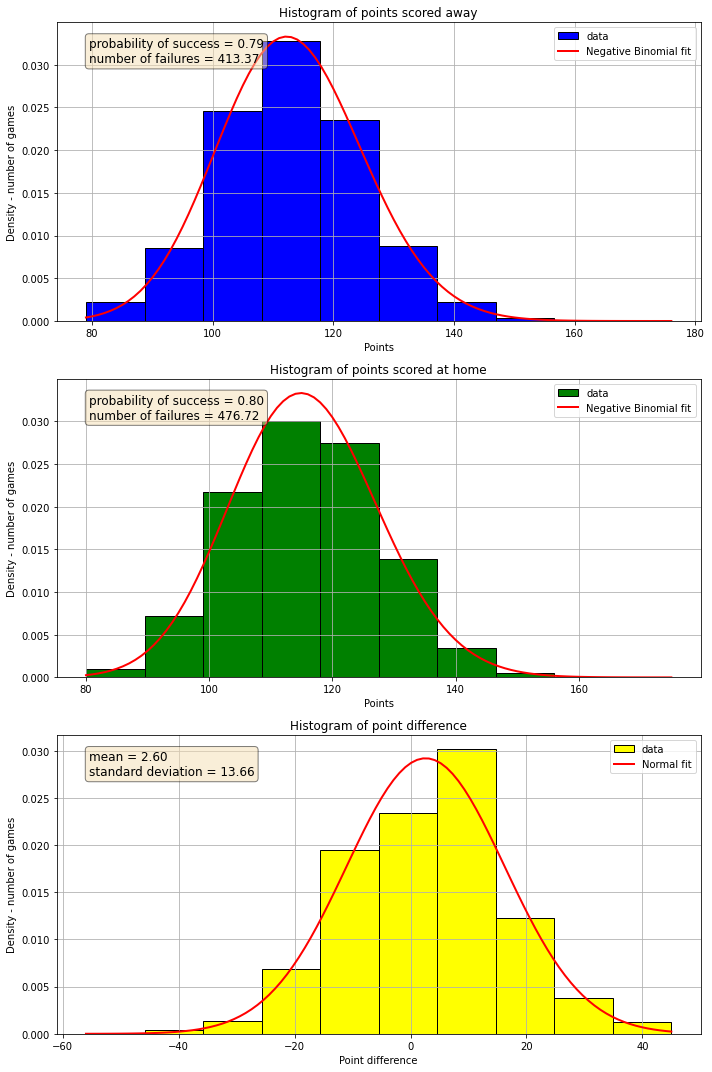

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=10, color='blue', edgecolor='black', label='data')
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=10, color='green', edgecolor='black', label='data')
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

# Histogram of point difference
axes[2].hist(seasons_games[year]['difference'], density=True, bins=10, color='yellow', edgecolor='black', label='data')
axes[2].set_title('Histogram of point difference')
axes[2].set_xlabel('Point difference')
axes[2].set_ylabel('Density - number of games')

# Plot the negative binomial PDF on each chart
for ax, col in zip(axes, ('away_team_score', 'home_team_score', 'difference')):
    mean, var = np.mean(seasons_games[year][col]), np.var(seasons_games[year][col])
    if col == 'difference':
        std = np.sqrt(var)
        x = np.linspace(min(seasons_games[year][col]), max(seasons_games[year][col]), 100)
        normal_pdf = norm.pdf(x, mean, std)
    
        # Plot the normal PDF
        ax.plot(x, normal_pdf, 'r-', lw=2, label='Normal fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    else:
        p = mean / var
        r = mean ** 2 / (var - mean)  # Number of failures
        x = np.arange(min(seasons_games[year][col]), max(seasons_games[year][col]) + 1)
        nbinom_pmf = nbinom.pmf(x, r, p)
            
        # Plot the negative binomial PDF
        ax.plot(x, nbinom_pmf, 'r-', lw=2, label='Negative Binomial fit')
        
        textstr = f'probability of success = {p:.2f}\nnumber of failures = {r:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    ax.legend()
    ax.grid()

plt.tight_layout()

Prepare input data

In [8]:
inp_data = {
    'teams_number': len(teams),
    'games_number': len(seasons_games[train_year]),
    'home_team': seasons_games[train_year].home_team_id.to_numpy(),
    'away_team': seasons_games[train_year].away_team_id.to_numpy(),
    'home_score': seasons_games[train_year].home_team_score.to_numpy(),
    'away_score': seasons_games[train_year].away_team_score.to_numpy(),
}

Modelling

## Model 1 - poisson

### Prior

In [43]:
with open('src/model/model_1_prior.stan', 'r') as f:
    print(f.read())

generated quantities{
    int home_score_pred;
    int away_score_pred;

    real mu_home_att;
    real mu_away_att;
    real mu_home_def;
    real mu_away_def;
    real sigma2_att;
    real sigma2_def;

    real log_mu_home;
    real log_mu_away;
    real home_att;
    real away_att;
    real home_def;
    real away_def;

    mu_home_att = normal_rng(4, 0.5);  // Adjusted for higher scores
    mu_away_att = normal_rng(4, 0.5);  // Adjusted for higher scores
    mu_home_def = normal_rng(4, 0.5);  // Adjusted for higher scores
    mu_away_def = normal_rng(4, 0.5);  // Adjusted for higher scores
    sigma2_att = gamma_rng(2, 0.1);
    sigma2_def = gamma_rng(2, 0.1);

    home_att = normal_rng(mu_home_att, sigma2_att);
    away_att = normal_rng(mu_away_att, sigma2_att);
    home_def = normal_rng(mu_home_def, sigma2_def);
    away_def = normal_rng(mu_away_def, sigma2_def);

    log_mu_home = home_att + away_def + log(mu_home_att);
    log_mu_away = away_att + home_def + log(mu_away_att);



In [64]:
model_1_prior = CmdStanModel(stan_file='src/model/model_1_prior.stan')
samples = 1000
sim1p=model_1_prior.sample(iter_sampling=samples)

INFO:cmdstanpy:compiling stan file /app/src/model/model_1_prior.stan to exe file /app/src/model/model_1_prior
INFO:cmdstanpy:compiled model executable: /app/src/model/model_1_prior
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


/tmp/ipykernel_6354/1729345633.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim1p.stan_variable(param), ax=ax, join=False)


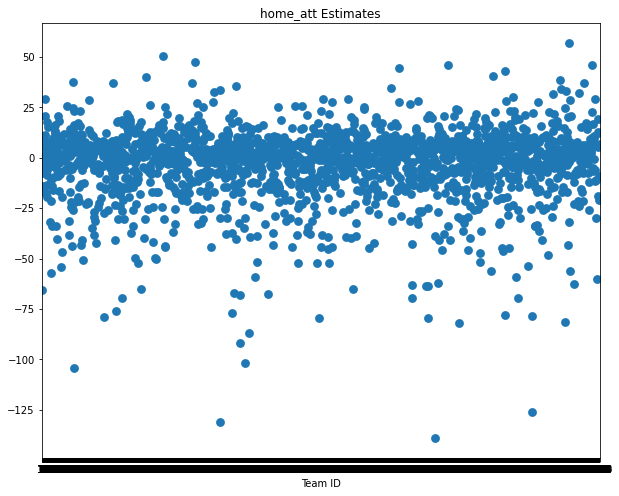

/tmp/ipykernel_6354/1729345633.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim1p.stan_variable(param), ax=ax, join=False)


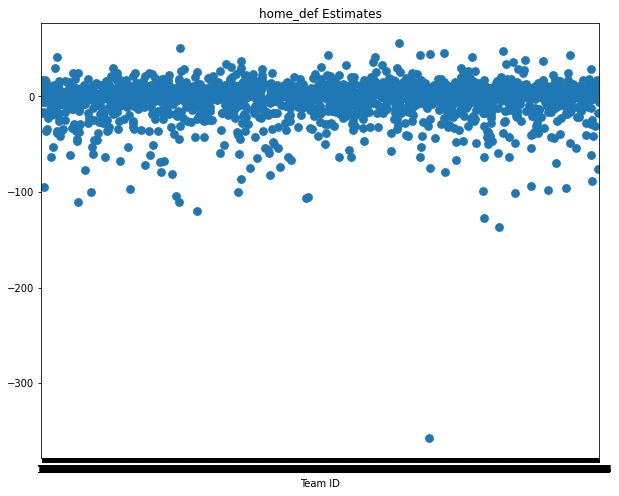

/tmp/ipykernel_6354/1729345633.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim1p.stan_variable(param), ax=ax, join=False)


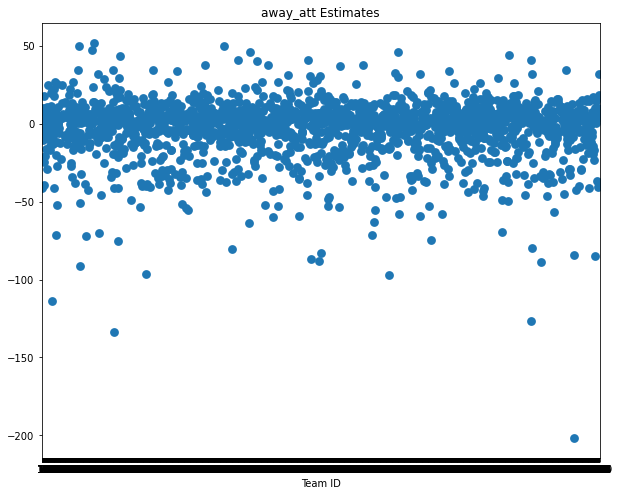

/tmp/ipykernel_6354/1729345633.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim1p.stan_variable(param), ax=ax, join=False)


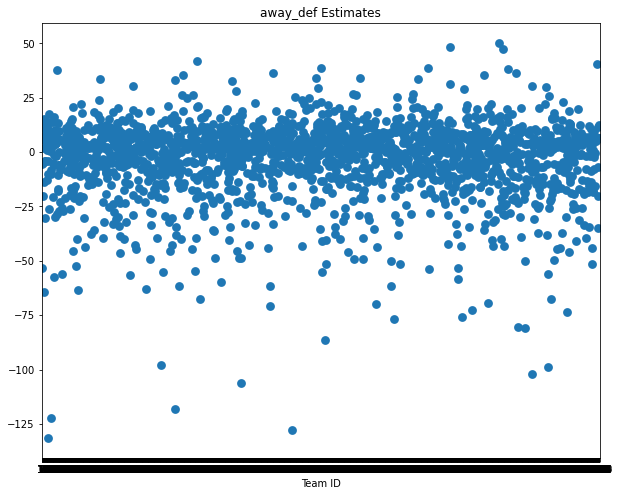

In [45]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
    
for param in parameters:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.pointplot(data=sim1p.stan_variable(param), ax=ax, join=False)
    ax.set_title(f'{param} Estimates')
    ax.set_xlabel('Team ID')
    plt.show()

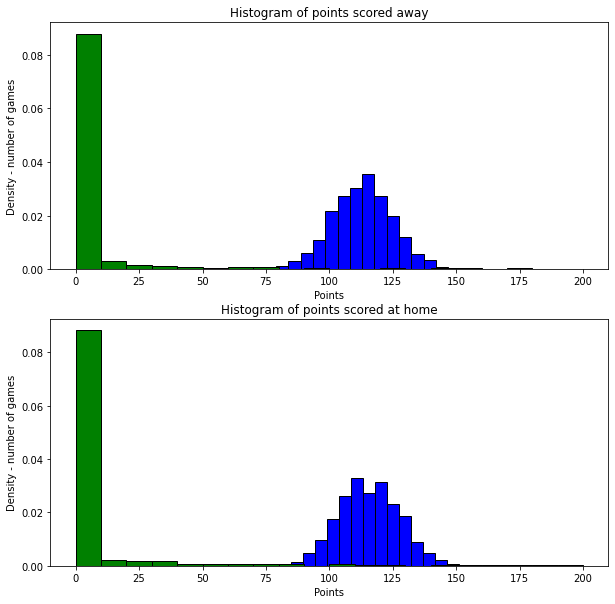

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim1p.stan_variable('away_score_pred'), density=True, bins=20, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim1p.stan_variable('home_score_pred'), density=True, bins=20, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')
fig.show()

### Posterior

In [9]:
with open('src/model/model_1.stan', 'r') as f:
    print(f.read())

data {
  int teams_number;
  int games_number;
  array[games_number] int home_team;
  array[games_number] int away_team;
  array[games_number] int<lower=0> home_score;
  array[games_number] int<lower=0> away_score;
}
parameters {
  real mu_home_att;
  real mu_away_att;
  real mu_home_def;
  real mu_away_def;
  real<lower=0> sigma2_att;
  real<lower=0> sigma2_def;

  vector[teams_number-1] home_att_raw;
  vector[teams_number-1] away_att_raw;
  vector[teams_number-1] home_def_raw;
  vector[teams_number-1] away_def_raw;
}
transformed parameters {
  vector[games_number] log_mu_home;
  vector[games_number] log_mu_away;
  vector[teams_number] home_att;
  vector[teams_number] away_att;
  vector[teams_number] home_def;
  vector[teams_number] away_def;

  // need to make sum(att)=sum(def)=0
  for (k in 1:(teams_number-1)) {
    home_att[k] = home_att_raw[k];
    away_att[k] = away_att_raw[k];
    home_def[k] = home_def_raw[k];
    away_def[k] = away_att_raw[k];
  }
  home_att[teams_number] = -s

In [26]:
model_1 = CmdStanModel(stan_file='src/model/model_1.stan')
samples = 1000
sim1=model_1.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=500,
                     chains=4,
                     fixed_param=False,
                     parallel_chains=4,
                     seed=122,
                     refresh=samples)

INFO:cmdstanpy:compiling stan file /app/src/model/model_1.stan to exe file /app/src/model/model_1
INFO:cmdstanpy:compiled model executable: /app/src/model/model_1
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██████▋   | 00:10 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |██████████| 00:22 Iteration:  501 / 1500 [ 33%]  (Sampling)

chain 1 |██████████| 00:25 Sampling completed                       
chain 2 |██████████| 00:25 Sampling completed                       
chain 3 |██████████| 00:25 Sampling completed                       
chain 4 |██████████| 00:25 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [15]:
mod_1 = sim1.draws_pd()
mod_1.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu_home_att,mu_away_att,mu_home_def,...,away_score_pred[1314],away_score_pred[1315],away_score_pred[1316],away_score_pred[1317],away_score_pred[1318],away_score_pred[1319],away_score_pred[1320],away_score_pred[1321],away_score_pred[1322],away_score_pred[1323]
0,1045910.0,0.967513,0.080498,6.0,63.0,0.0,-1045840.0,87.4408,87.0981,-0.007656,...,70.0,74.0,77.0,98.0,77.0,101.0,81.0,103.0,76.0,94.0
1,1045910.0,0.962244,0.080498,6.0,63.0,0.0,-1045850.0,87.1772,87.3996,0.000470,...,77.0,69.0,79.0,85.0,100.0,101.0,84.0,85.0,74.0,72.0
2,1045920.0,0.829383,0.080498,6.0,63.0,0.0,-1045870.0,87.5122,87.1952,0.005461,...,89.0,46.0,93.0,81.0,94.0,92.0,69.0,72.0,105.0,91.0
3,1045930.0,0.999915,0.080498,6.0,63.0,0.0,-1045870.0,87.1355,86.8561,0.007986,...,93.0,59.0,85.0,72.0,115.0,81.0,95.0,93.0,83.0,84.0
4,1045920.0,0.926650,0.080498,6.0,63.0,0.0,-1045860.0,87.1552,87.2933,-0.001805,...,89.0,65.0,75.0,76.0,86.0,92.0,86.0,96.0,84.0,96.0


2023


/tmp/ipykernel_6354/3917854911.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim1.stan_variable(param), ax=ax, join=False)


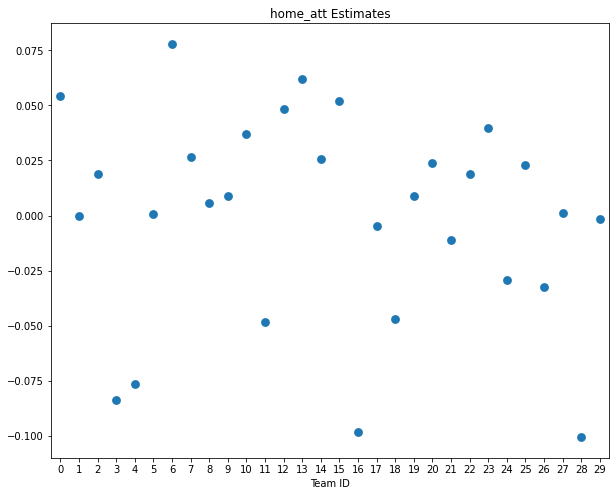

/tmp/ipykernel_6354/3917854911.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim1.stan_variable(param), ax=ax, join=False)


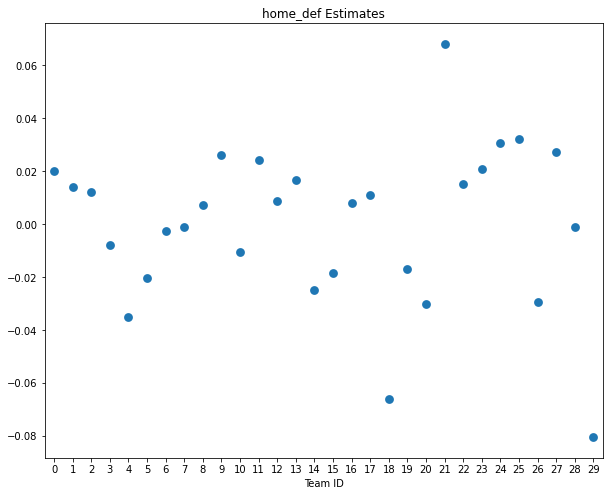

/tmp/ipykernel_6354/3917854911.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim1.stan_variable(param), ax=ax, join=False)


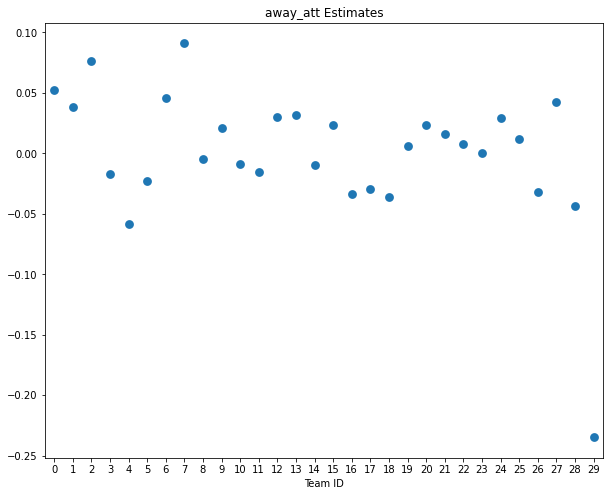

/tmp/ipykernel_6354/3917854911.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim1.stan_variable(param), ax=ax, join=False)


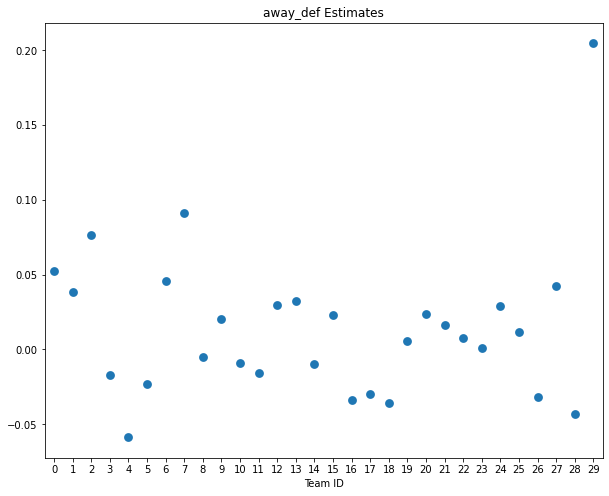

In [16]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
print(year)
for param in parameters:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.pointplot(data=sim1.stan_variable(param), ax=ax, join=False)
    ax.set_xticks(range(len(teams)))
    ax.set_title(f'{param} Estimates')
    ax.set_xlabel('Team ID')
    plt.show()

In [29]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
param_dict = {param: sim1.stan_variable(param) for param in parameters}

# Przykładowe dane do przewidywania (przykładowe ID drużyn)

season_games_pred1 = {2023: seasons_games[2023][1100:1200]}

correct_predictions = 0
incorrect_predictions = 0

# Przewidywanie wyników dla każdego meczu
for idx, row in season_games_pred1[pred_year].iterrows():
    home_idx = row['home_team_id']
    away_idx = row['away_team_id']
    home_score = row['home_team_score']
    away_score = row['away_team_score']
    
    # Pobieranie odpowiednich parametrów dla drużyn
    home_att = param_dict['home_att'][:, home_idx-1]
    home_def = param_dict['home_def'][:, away_idx-1]
    away_att = param_dict['away_att'][:, home_idx-1]
    away_def = param_dict['away_def'][:, away_idx-1]
    
    # Tworzenie parametrów log_mu
    log_mu1 = home_att + away_def + np.log(home_score)
    log_mu2 = home_def + away_att + np.log(away_score)
    
    # Symulowanie z rozkładu Poissona dla uzyskania predyktywnej dystrybucji
    y1 = np.array([poisson.rvs(np.exp(log_mu1[i])) for i in range(samples)])
    y2 = np.array([poisson.rvs(np.exp(log_mu2[i])) for i in range(samples)])
    print(y1[0:10], y2[0:10])
    # draw blocked
    y1 = y1 + (y1 == y2) * np.random.choice([-1, 1], size=samples)
    
     # Calculating outcome probabilities
    home_win_prob = np.mean(y1 > y2)
    away_win_prob = np.mean(y1 < y2)
    # Calculating outcome probabilities
    outcome_probabilities = pd.DataFrame({
        'home_team_win_prob': [home_win_prob],
        'away_team_win_prob': [away_win_prob]
    })
    
    # Printing results
    predicted_winner = 'home wins' if home_win_prob > 0.5 else 'away wins'
    
    # Determine actual winner
    actual_winner = 'home wins' if row['home_team_score'] > row['away_team_score'] else 'away wins'
    
    # Check if prediction is correct
    if predicted_winner == actual_winner:
        correct_predictions += 1
    else:
        incorrect_predictions += 1
    
    # Printing results
    print(f"Game {idx + 1}:")
    print(outcome_probabilities)
    print(f"Home Team Points Distribution: {np.mean(y1)} ± {np.std(y1)}")
    print(f"Away Team Points Distribution: {np.mean(y2)} ± {np.std(y2)}")
    print(f"Predicted Winner: {predicted_winner}")
    print(f"Actual Winner: {actual_winner}\n")

# Print summary of predictions
print(f"Total Correct Predictions: {correct_predictions}")
print(f"Total Incorrect Predictions: {incorrect_predictions}")
print(f"Prediction Accuracy: {correct_predictions / (correct_predictions + incorrect_predictions):.2f}")

[124 109 126 107 118 123 132  98 127 122] [ 91 104  96 101 107  78  94  74  99 111]
Game 1101:
   home_team_win_prob  away_team_win_prob
0               0.951               0.049
Home Team Points Distribution: 117.711 ± 10.76036611830657
Away Team Points Distribution: 93.897 ± 9.7980809855808
Predicted Winner: home wins
Actual Winner: away wins

[135 122 119 126 113 143 126 130 132 118] [144 130 140 135 136 161 132 162 169 158]
Game 1102:
   home_team_win_prob  away_team_win_prob
0               0.107               0.893
Home Team Points Distribution: 126.638 ± 10.814756400400334
Away Team Points Distribution: 145.691 ± 11.950377358058613
Predicted Winner: away wins
Actual Winner: away wins

[122 137 132 135 130 114 139 116 131 153] [106 130 128  98 102 116 121 109 111 119]
Game 1103:
   home_team_win_prob  away_team_win_prob
0               0.822               0.178
Home Team Points Distribution: 127.391 ± 11.145766864599313
Away Team Points Distribution: 112.428 ± 10.641936665851755


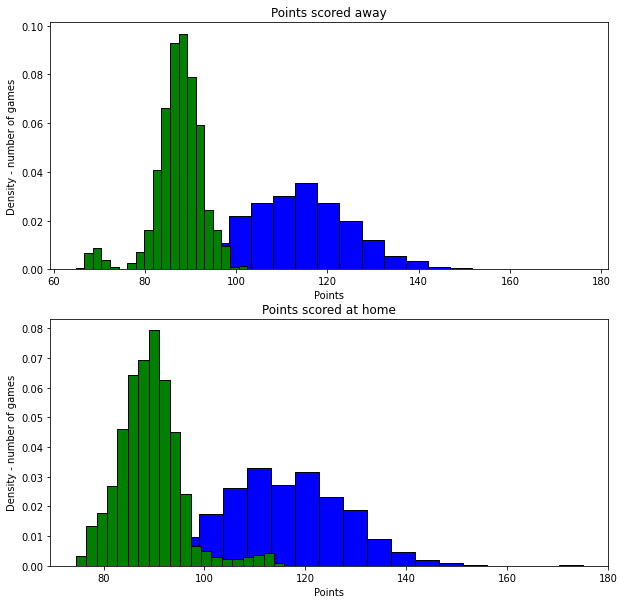

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim1.stan_variable('away_score_pred').mean(axis=0), density=True, bins=20, color='green', edgecolor='black', label='data')
axes[0].set_title('Points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim1.stan_variable('home_score_pred').mean(axis=0), density=True, bins=20, color='green', edgecolor='black', label='data')
axes[1].set_title('Points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

fig.show()

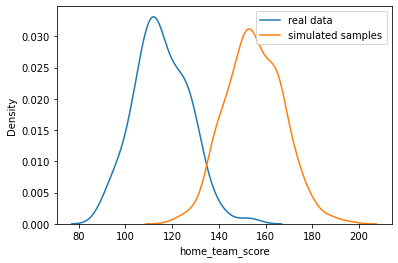

In [20]:
sns.kdeplot(data=season_games_pred1[2023], x='home_team_score', label='real data')
sns.kdeplot(data=y1, label='simulated samples')
plt.legend(loc='best')
plt.show()

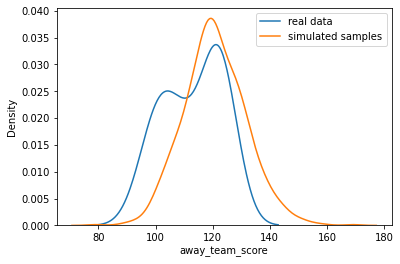

In [221]:
sns.kdeplot(data=season_games_pred1[2023], x='away_team_score', label='real data')
sns.kdeplot(data=y2, label='simulated samples')
plt.legend(loc='best')
plt.show()

## Model 2 - poisson

In [222]:
model_2 = CmdStanModel(stan_file='src/model/model_2.stan')
samples = 1000
sim2=model_2.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=500,
                     chains=4,
                     fixed_param=False,
                     parallel_chains=4,
                     seed=123,
                     refresh=samples)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██████▋   | 00:02 Iteration:    1 / 1500 [  0%]  (Warmup)

chain 1 |██████████| 00:06 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                       
chain 2 |██████████| 00:07 Sampling completed                       
chain 3 |██████████| 00:07 Sampling completed                       
chain 4 |██████████| 00:07 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [223]:
mod_2 = sim2.draws_pd()
mod_2.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu_att,mu_def,sigma_att,...,log_mu_away[1314],log_mu_away[1315],log_mu_away[1316],log_mu_away[1317],log_mu_away[1318],log_mu_away[1319],log_mu_away[1320],log_mu_away[1321],log_mu_away[1322],log_mu_away[1323]
0,1081490.0,0.927273,0.144674,4.0,15.0,0.0,-1081470.0,0.405520,0.305789,0.040716,...,4.62488,4.63309,4.62819,4.62488,4.65342,4.65342,4.64779,4.64779,4.65342,4.64779
1,1081490.0,0.866827,0.144674,3.0,15.0,0.0,-1081460.0,0.377357,0.299022,0.038382,...,4.65556,4.61498,4.63821,4.65556,4.63952,4.63952,4.63178,4.63178,4.63952,4.63178
2,1081500.0,0.990403,0.144674,4.0,15.0,0.0,-1081460.0,0.395683,0.293137,0.025450,...,4.63746,4.61665,4.63304,4.63746,4.65094,4.65094,4.66357,4.66357,4.65094,4.66357
3,1081510.0,0.910428,0.144674,3.0,7.0,0.0,-1081470.0,0.385827,0.298721,0.026466,...,4.64845,4.62296,4.63164,4.64845,4.66909,4.66909,4.65977,4.65977,4.66909,4.65977
4,1081500.0,0.533601,0.144674,3.0,7.0,0.0,-1081470.0,0.389470,0.297563,0.029138,...,4.64718,4.61960,4.62111,4.64718,4.63926,4.63926,4.62641,4.62641,4.63926,4.62641


In [235]:
season_games_pred2 = {2023: seasons_games[2023][200:300]}

# Number of samples for simulation
samples = 1000

# Extracting parameters from the Stan result
parameters = ['attack', 'defense', 'home_advantage']
param_dict = {param: sim2.stan_variable(param) for param in parameters}

correct_predictions = 0
incorrect_predictions = 0

# Predicting results for each game
for idx, row in season_games_pred2[pred_year].iterrows():
    home_idx = row['home_team_id']
    away_idx = row['away_team_id']
    
    # Retrieving appropriate parameters for the teams
    home_att = param_dict['attack'][:, home_idx-1]
    home_def = param_dict['defense'][:, home_idx-1]
    away_att = param_dict['attack'][:, away_idx-1]
    away_def = param_dict['defense'][:, away_idx-1]
    home_advantage = param_dict['home_advantage']
    
    # Creating log_mu parameters
    log_mu1 = home_advantage + home_att - away_def + np.log(100)
    log_mu2 = away_att - home_def + np.log(100)
    
    # Simulating from Poisson distribution to obtain predictive distribution
    y1 = np.array([poisson.rvs(np.exp(log_mu1[i])) for i in range(samples)])
    y2 = np.array([poisson.rvs(np.exp(log_mu2[i])) for i in range(samples)])
    
    # Blocking draws
    y1 = y1 + (y1 == y2) * np.random.choice([-1, 1], size=samples)
    print(y1[0:10], y2[0:10])
    # Calculating outcome probabilities
    home_win_prob = np.mean(y1 > y2)
    away_win_prob = np.mean(y1 < y2)
    # Calculating outcome probabilities
    outcome_probabilities = pd.DataFrame({
        'home_team_win_prob': [home_win_prob],
        'away_team_win_prob': [away_win_prob]
    })
    
    # Printing results
    predicted_winner = 'home wins' if home_win_prob > 0.5 else 'away wins'
    
    # Determine actual winner
    actual_winner = 'home wins' if row['home_team_score'] > row['away_team_score'] else 'away wins'
    
    # Check if prediction is correct
    if predicted_winner == actual_winner:
        correct_predictions += 1
    else:
        incorrect_predictions += 1
    
    # Printing results
    print(f"Game {idx + 1}:")
    print(outcome_probabilities)
    print(f"Home Team Points Distribution: {np.mean(y1)} ± {np.std(y1)}")
    print(f"Away Team Points Distribution: {np.mean(y2)} ± {np.std(y2)}")
    print(f"Predicted Winner: {predicted_winner}")
    print(f"Actual Winner: {actual_winner}\n")

# Print summary of predictions
print(f"Total Correct Predictions: {correct_predictions}")
print(f"Total Incorrect Predictions: {incorrect_predictions}")
print(f"Prediction Accuracy: {correct_predictions / (correct_predictions + incorrect_predictions):.2f}")

[102 121 102  99 108 101  85  98 107 118] [ 77 111  96  92  95  95  84 107 108  85]
Game 201:
   home_team_win_prob  away_team_win_prob
0               0.855               0.145
Home Team Points Distribution: 112.251 ± 10.820166311106314
Away Team Points Distribution: 97.652 ± 9.974311805834024
Predicted Winner: home wins
Actual Winner: home wins

[110 128  97  84 103 113 124 110 117 114] [126 134 119 104 115 119 108 117 109 106]
Game 202:
   home_team_win_prob  away_team_win_prob
0               0.517               0.483
Home Team Points Distribution: 107.77 ± 10.295974941694448
Away Team Points Distribution: 107.154 ± 10.554064809351893
Predicted Winner: home wins
Actual Winner: home wins

[128 109 115 111 120 103 125 118 123 107] [110 105 113 117 116 110 107 107 121 117]
Game 203:
   home_team_win_prob  away_team_win_prob
0                 0.6                 0.4
Home Team Points Distribution: 116.415 ± 10.404651603970215
Away Team Points Distribution: 112.572 ± 10.973915253910064
P

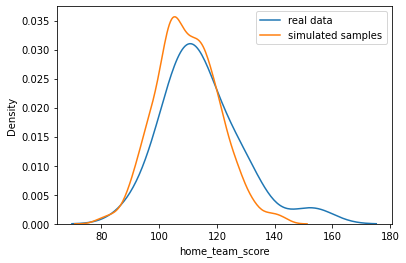

In [225]:
sns.kdeplot(data=season_games_pred2[2023], x='home_team_score', label='real data')
sns.kdeplot(data=y1, label='simulated samples')
plt.legend(loc='best')
plt.show()

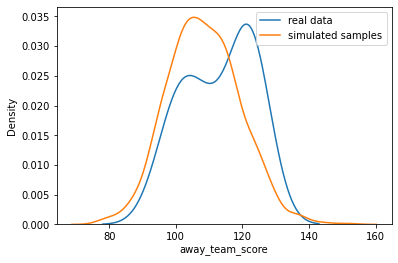

In [226]:
sns.kdeplot(data=season_games_pred2[2023], x='away_team_score', label='real data')
sns.kdeplot(data=y2, label='simulated samples')
plt.legend(loc='best')
plt.show()

## Model 3 

In [227]:
inp_data_3 = {
    'N_teams': len(teams),
    'N_games': len(seasons_games[train_year]),
    'home_team': seasons_games[train_year].home_team_id.to_numpy(),
    'away_team': seasons_games[train_year].away_team_id.to_numpy(),
    'home_points': seasons_games[train_year].home_team_score.to_numpy(),
    'away_points': seasons_games[train_year].away_team_score.to_numpy(),
    'home_field_advantage_threshold': 2
}

In [228]:
model_3 = CmdStanModel(stan_file='src/model/model_3.stan')
samples = 1000
sim3=model_3.sample(data=inp_data_3,
                     iter_sampling=samples,
                     iter_warmup=500,
                     chains=4,
                     fixed_param=False,
                     parallel_chains=4,
                     seed=124,
                     refresh=samples)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██████▋   | 00:13 Iteration:    1 / 1500 [  0%]  (Warmup)




chain 1 |██████████| 00:21 Sampling completed                       
chain 2 |██████████| 00:21 Sampling completed                       
chain 3 |██████████| 00:21 Sampling completed                       
chain 4 |██████████| 00:21 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [229]:
mod_3 = sim3.draws_pd()
mod_3.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta_offense[1],theta_offense[2],theta_offense[3],...,theta_offense_centered[21],theta_offense_centered[22],theta_offense_centered[23],theta_offense_centered[24],theta_offense_centered[25],theta_offense_centered[26],theta_offense_centered[27],theta_offense_centered[28],theta_offense_centered[29],theta_offense_centered[30]
0,-7928.06,0.811434,0.35945,4.0,15.0,0.0,7969.23,114.211,111.924,113.770,...,0.173684,-3.317860,0.250637,2.56174,1.031600,0.438743,-2.21490,3.37455,-5.15010,-3.80215
1,-7929.99,0.902686,0.35945,4.0,15.0,0.0,7962.83,116.280,112.493,113.735,...,0.077954,-1.650990,-0.632808,1.60885,-0.441284,-0.136124,-1.54858,3.16746,-4.05674,-3.42741
2,-7935.52,0.859278,0.35945,4.0,15.0,0.0,7961.54,112.677,113.505,114.640,...,1.104280,-1.141710,-1.013110,1.76038,0.286916,0.893158,-2.39948,1.43580,-5.66495,-3.20855
3,-7932.32,0.987520,0.35945,4.0,31.0,0.0,7967.55,114.732,110.398,115.005,...,-0.858091,0.248458,1.364290,2.40585,0.479458,1.413550,-1.59283,3.74197,-6.79833,-1.15782
4,-7933.66,0.871092,0.35945,4.0,15.0,0.0,7967.35,113.897,114.051,115.310,...,1.215470,-1.302500,-0.642919,1.15057,-0.527805,0.412202,-2.36681,1.22535,-4.03623,-3.28519


In [236]:

# Przykładowe dane do przewidywania (przykładowe ID drużyn)

season_games_pred3 = {2023: seasons_games[2023][200:300]}

# Extracting parameters from the Stan result
parameters = ['theta_offense', 'theta_defense', 'home_field_advantage', 'sigma_points']
param_dict = {param: sim3.stan_variable(param) for param in parameters}

# Initialize counters for correct and incorrect predictions
correct_predictions = 0
incorrect_predictions = 0

# Predicting results for each game
for idx, row in season_games_pred3[2023].iterrows():
    home_idx = row['home_team_id'] - 1
    away_idx = row['away_team_id'] - 1
    
    # Retrieving appropriate parameters for the teams
    home_off = param_dict['theta_offense'][:, home_idx]
    home_def = param_dict['theta_defense'][:, home_idx]
    away_off = param_dict['theta_offense'][:, away_idx]
    away_def = param_dict['theta_defense'][:, away_idx]
    home_advantage = param_dict['home_field_advantage']
    sigma_points = param_dict['sigma_points']
    
    # Creating mean parameters for the normal distribution
    mean_home = home_advantage + home_off + away_def
    mean_away = away_off + home_def
    
    # Simulating from normal distribution to obtain predictive distribution
    y1 = np.array([norm.rvs(loc=mean_home[i], scale=sigma_points[i]) for i in range(samples)])
    y2 = np.array([norm.rvs(loc=mean_away[i], scale=sigma_points[i]) for i in range(samples)])
    
    # Blocking draws
    y1 = y1 + (y1 == y2) * np.random.choice([-1, 1], size=samples)
    
    home_win_prob = np.mean(y1 > y2)
    away_win_prob = np.mean(y1 < y2)
    # Calculating outcome probabilities
    outcome_probabilities = pd.DataFrame({
        'home_team_win_prob': [home_win_prob],
        'away_team_win_prob': [away_win_prob]
    })
    
    
    # Printing resultS
    # Determine predicted winner
    predicted_winner = 'home wins' if home_win_prob > 0.5 else 'away wins'
    
    # Determine actual winner
    actual_winner = 'home wins' if row['home_team_score'] > row['away_team_score'] else 'away wins'
    
    # Check if prediction is correct
    if predicted_winner == actual_winner:
        correct_predictions += 1
    else:
        incorrect_predictions += 1
    
    # Printing results
    print(f"Game {idx + 1}:")
    print(outcome_probabilities)
    print(f"Home Team Points Distribution: {np.mean(y1)} ± {np.std(y1)}")
    print(f"Away Team Points Distribution: {np.mean(y2)} ± {np.std(y2)}")
    print(f"Predicted Winner: {predicted_winner}")
    print(f"Actual Winner: {actual_winner}\n")

# Print summary of predictions
print(f"Total Correct Predictions: {correct_predictions}")
print(f"Total Incorrect Predictions: {incorrect_predictions}")
print(f"Prediction Accuracy: {correct_predictions / (correct_predictions + incorrect_predictions):.2f}")


Game 201:
   home_team_win_prob  away_team_win_prob
0               0.785               0.215
Home Team Points Distribution: 111.56978888002433 ± 11.690252500973171
Away Team Points Distribution: 97.985391966423 ± 11.754749567142195
Predicted Winner: home wins
Actual Winner: home wins

Game 202:
   home_team_win_prob  away_team_win_prob
0               0.507               0.493
Home Team Points Distribution: 107.6506091240781 ± 11.824798136964318
Away Team Points Distribution: 107.50926541459593 ± 11.348014936582947
Predicted Winner: home wins
Actual Winner: home wins

Game 203:
   home_team_win_prob  away_team_win_prob
0               0.579               0.421
Home Team Points Distribution: 115.91811393461667 ± 11.973619461588546
Away Team Points Distribution: 112.93484780116155 ± 12.401251025632227
Predicted Winner: home wins
Actual Winner: away wins

Game 204:
   home_team_win_prob  away_team_win_prob
0               0.375               0.625
Home Team Points Distribution: 108.73301

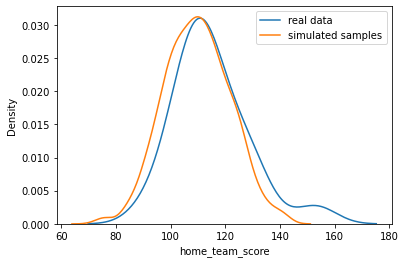

In [231]:
sns.kdeplot(data=season_games_pred3[2023], x='home_team_score', label='real data')
sns.kdeplot(data=y1, label='simulated samples')
plt.legend(loc='best')
plt.show()

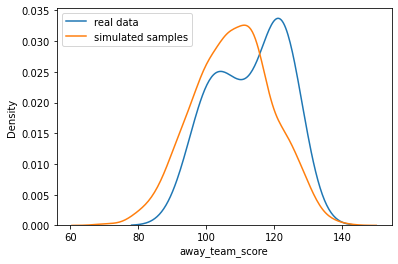

In [232]:
sns.kdeplot(data=season_games_pred3[2023], x='away_team_score', label='real data')
sns.kdeplot(data=y2, label='simulated samples')
plt.legend(loc='best')
plt.show()

In [25]:
model_normal_prior = CmdStanModel(stan_file='src/model/model_normal_prior.stan')
samples = 1000
sim_normal_prior=model_normal_prior.sample(iter_sampling=samples)

INFO:cmdstanpy:compiling stan file /app/src/model/model_normal_prior.stan to exe file /app/src/model/model_normal_prior
INFO:cmdstanpy:compiled model executable: /app/src/model/model_normal_prior
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [26]:
mod_norm_pri = sim_normal_prior.draws_pd()
print(mod_norm_pri)

      lp__  accept_stat__  home_score_pred  away_score_pred  mu_home_att  \
0      0.0            0.0         154.0410         139.2520      17.9146   
1      0.0            0.0         118.8120         140.7280      25.9026   
2      0.0            0.0         112.9660         112.2980      25.3750   
3      0.0            0.0         114.8710         129.9730      17.6780   
4      0.0            0.0          85.7596          91.0852      24.8577   
...    ...            ...              ...              ...          ...   
3995   0.0            0.0         182.5190          84.5522      32.4863   
3996   0.0            0.0         102.5750         102.1760      15.8219   
3997   0.0            0.0         132.4630         107.3130      21.2067   
3998   0.0            0.0         150.2780         121.5220      20.2074   
3999   0.0            0.0         127.9300         118.9730      20.5803   

      mu_away_att  mu_home_def  mu_away_def  sigma2_att  sigma2_def  phi_home  \
0     

Text(0, 0.5, 'Density - number of games')

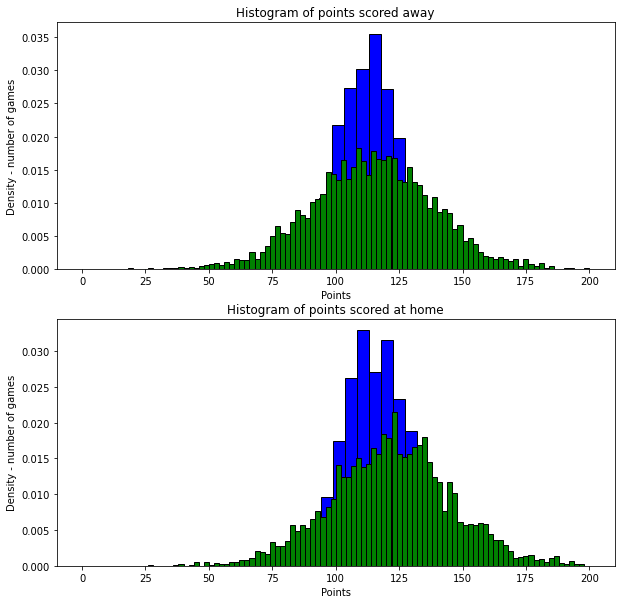

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_normal_prior.stan_variable('away_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_normal_prior.stan_variable('home_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

In [29]:
model_nbinomial_prior = CmdStanModel(stan_file='src/model/model_nbinomial_prior.stan')
samples = 1000
sim_nbin_prior=model_nbinomial_prior.sample(iter_sampling=samples)

INFO:cmdstanpy:compiling stan file /app/src/model/model_nbinomial_prior.stan to exe file /app/src/model/model_nbinomial_prior
INFO:cmdstanpy:compiled model executable: /app/src/model/model_nbinomial_prior
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [30]:
mod_nbin_prior = sim_nbin_prior.draws_pd()
print(mod_nbin_prior)

      lp__  accept_stat__  home_score_pred  away_score_pred  mu_home_att  \
0      0.0            0.0            138.0             86.0     0.487737   
1      0.0            0.0            110.0             90.0     1.769790   
2      0.0            0.0            209.0            132.0     0.808892   
3      0.0            0.0            113.0             94.0    -0.976051   
4      0.0            0.0            161.0             59.0     0.683068   
...    ...            ...              ...              ...          ...   
3995   0.0            0.0            136.0            103.0    -0.113655   
3996   0.0            0.0            162.0            131.0    -0.328396   
3997   0.0            0.0            116.0            125.0    -0.907743   
3998   0.0            0.0            157.0            133.0    -2.255070   
3999   0.0            0.0            104.0            115.0    -0.087807   

      mu_away_att  mu_home_def  mu_away_def  sigma2_att  sigma2_def  phi_home  \
0     

Text(0, 0.5, 'Density - number of games')

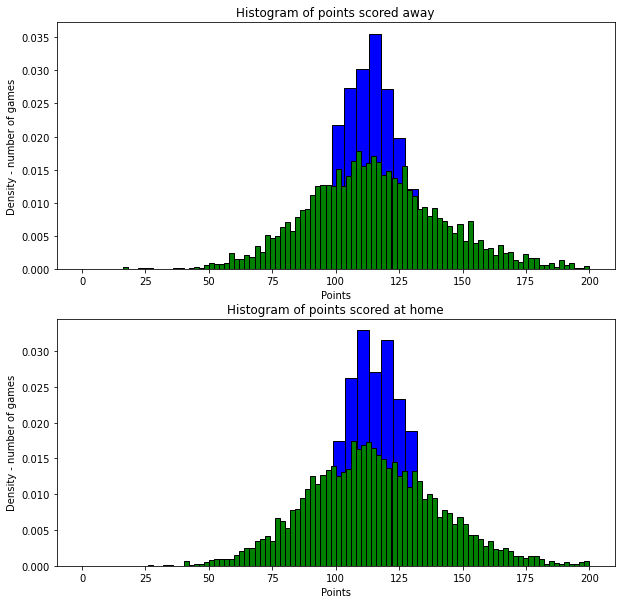

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_nbin_prior.stan_variable('away_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_nbin_prior.stan_variable('home_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

In [9]:
model_normal_posterior = CmdStanModel(stan_file='src/model/model_normal_posterior.stan')
samples = 10000
sim_nor_post=model_normal_posterior.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1
                     )

INFO:cmdstanpy:compiling stan file /app/src/model/model_normal_posterior.stan to exe file /app/src/model/model_normal_posterior
INFO:cmdstanpy:compiled model executable: /app/src/model/model_normal_posterior
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:25 Sampling completed                         


INFO:cmdstanpy:CmdStan done processing.


In [10]:
mod_norm_post = sim_nor_post.draws_pd()
print(mod_norm_post)

            lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -11764400.0            0.0     14.3855          0.0           1.0   
1    -11764400.0            0.0     14.3855          0.0           1.0   
2    -11764400.0            0.0     14.3855          0.0           1.0   
3    -11764400.0            0.0     14.3855          0.0           1.0   
4    -11764400.0            0.0     14.3855          0.0           1.0   
...          ...            ...         ...          ...           ...   
9995 -11764400.0            0.0     14.3855          0.0           1.0   
9996 -11764400.0            0.0     14.3855          0.0           1.0   
9997 -11764400.0            0.0     14.3855          0.0           1.0   
9998 -11764400.0            0.0     14.3855          0.0           1.0   
9999 -11764400.0            0.0     14.3855          0.0           1.0   

      divergent__    energy__  mu_home_att  mu_away_att  mu_home_def  ...  \
0             1.0  11764400.0     

In [11]:
print(max(sim_nor_post.stan_variable('mu_home_att')))

-1.93568


Text(0, 0.5, 'Density - number of games')

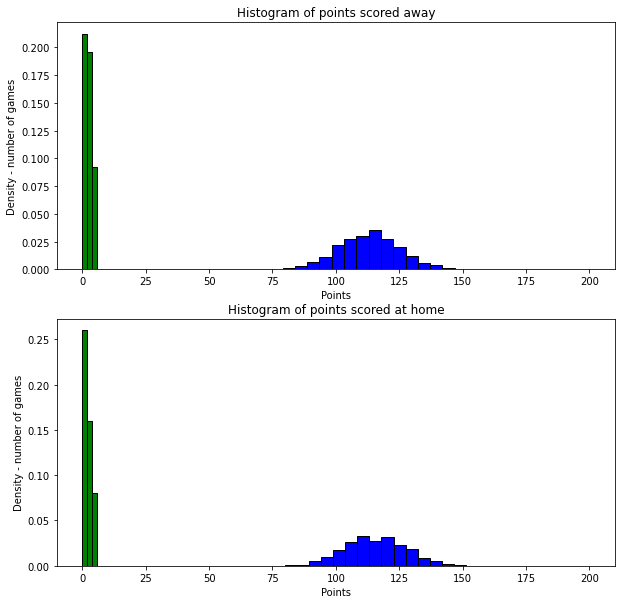

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_nor_post.stan_variable('away_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_nor_post.stan_variable('home_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

In [13]:
model_1_post = CmdStanModel(stan_file='src/model/model_1_posterior.stan')
samples = 10000
sim=model_1_post.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1
                     )

INFO:cmdstanpy:compiling stan file /app/src/model/model_1_posterior.stan to exe file /app/src/model/model_1_posterior
INFO:cmdstanpy:compiled model executable: /app/src/model/model_1_posterior
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:31 Sampling completed                         


INFO:cmdstanpy:CmdStan done processing.


In [14]:
mod_1_post = sim.draws_pd()
print(mod_1_post)

         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -20218.0            0.0     5.79578          0.0           1.0   
1    -20218.0            0.0     5.79578          0.0           1.0   
2    -20218.0            0.0     5.79578          0.0           1.0   
3    -20218.0            0.0     5.79578          0.0           1.0   
4    -20218.0            0.0     5.79578          0.0           1.0   
...       ...            ...         ...          ...           ...   
9995 -20218.0            0.0     5.79578          0.0           1.0   
9996 -20218.0            0.0     5.79578          0.0           1.0   
9997 -20218.0            0.0     5.79578          0.0           1.0   
9998 -20218.0            0.0     5.79578          0.0           1.0   
9999 -20218.0            0.0     5.79578          0.0           1.0   

      divergent__  energy__  mu_home_att  mu_away_att  mu_home_def  ...  \
0             1.0   20282.7     -1.12241      1.58222    -0.783212  ... 

Text(0, 0.5, 'Density - number of games')

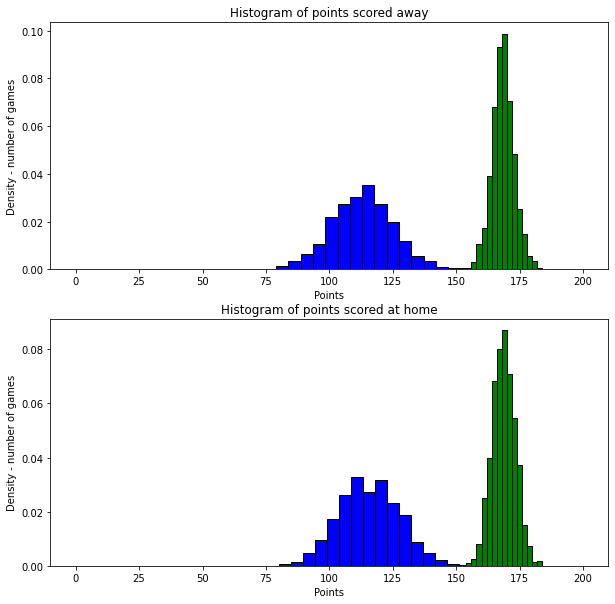

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim.stan_variable('away_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim.stan_variable('home_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

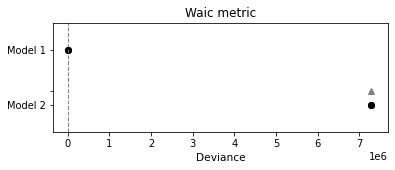

In [18]:
idata_nbin = az.from_cmdstanpy(posterior=sim_nor_post, log_likelihood={"home": "log_lik_home"})
idata_normal = az.from_cmdstanpy(posterior=sim, log_likelihood={"home": "log_lik_home"})

# Comparing models
comp_dict = {'Model 1': idata_normal, 'Model 2': idata_nbin}

comp_waic = az.compare(comp_dict, ic='waic', scale='deviance')
az.plot_compare(comp_waic)
plt.title("Waic metric")
plt.show()

/usr/local/lib/python3.12/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/lib/python3.12/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.12/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


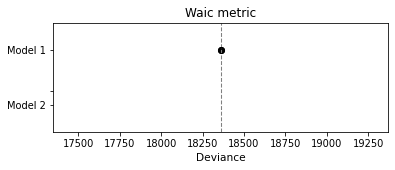

In [19]:
idata_nbin = az.from_cmdstanpy(posterior=sim_nor_post, log_likelihood={"away": "log_lik_away"})
idata_normal = az.from_cmdstanpy(posterior=sim, log_likelihood={"away": "log_lik_away"})

# Comparing models
comp_dict = {'Model 1': idata_normal, 'Model 2': idata_nbin}

comp_waic = az.compare(comp_dict, ic='waic', scale='deviance')
az.plot_compare(comp_waic)
plt.title("Waic metric")
plt.show()